In [164]:
import pandas as pd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
# La siguiente línea es para ver las imagenes dentro del notebook
%matplotlib inline
# Acá configuramos el tamaño de las figuras
plt.rcParams['figure.figsize'] = (12,8)
# Seteamos opciones de pandas sobre las columnas y su ancho
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 50)

In [167]:
# from google.colab import drive
# drive.mount('/content/drive')

# pd.read_csv('../data/properati_a_predecir.csv', index_col="id", parse_dates=['start_date', 'end_date', 'created_on']).to_parquet('../data/properati_a_predecir.parquet')
# pd.read_csv('../data/properati_entrenamiento.csv', index_col="id", parse_dates=['start_date', 'end_date', 'created_on']).to_parquet('../data/properati_entrenamiento.parquet')

# Lectura de datos

| Featire     | Descripción |
| ----------- | ----------- |
| id          | Identificador del aviso \*. |
| start_date | Fecha de alta del aviso. |
| end_date | Fecha de baja del aviso. |
| created_on | Fecha de alta de la primera versión del aviso. |
| lat | Latitud. |
| lon | Longitud. |
| l1 | Nivel administrativo 1: país. |
| l2 | Nivel administrativo 2: usualmente provincia. |
| l3 | Nivel administrativo 3: usualmente ciudad. |
| l4 | Nivel administrativo 4: usualmente barrio. |
| l5 | Nivel administrativo 5 |
| l6 | Nivel administrativo 6 |
| rooms | Cantidad de ambientes (útil en Argentina). |
| bedrooms | Cantidad de dormitorios (útil en el resto de los países). |
| bathrooms | Cantidad de baños. |
| surface_total | Superficie total en m². |
| surface_covered | Superficie cubierta en m². |
| price | Precio publicado en el anuncio. |
| currency | Moneda del precio publicado. |
| price_period | Periodo del precio (Diario, Semanal, Mensual) |
| title | Título del anuncio. |
| description | Descripción del anuncio. |
| property_type | Tipo de propiedad (Casa, Departamento, PH). |
| operation_type | Tipo de operación (Venta, Alquiler). |


\* No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.

In [270]:
# DIR = "/content/drive/MyDrive/Clases/FCEN DM/datos/"

# df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
# df_train.head()

# df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
# df_test.head()

df_train = pd.read_parquet('../data/properati_entrenamiento.parquet', engine="pyarrow")
# df_train = pd.read_parquet("../data/properati_a_predecir.parquet", engine="pyarrow")

In [271]:
df_train.head(2)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,,,,
1,Propiedad,2019-07-07,2019-07-10,2019-07-07,NaN,NaN,Argentina,Buenos Aires Interior,Urquiza,Urquiza,None,NaN,NaN,NaN,NaN,NaN,NaN,3800.0,ARS,Mensual,COCHERA EN ALQUILER,Xintel (SLC-SI1-560) Alquiler de Cochera en CA...,Cochera,Alquiler
2,Propiedad,2019-07-07,9999-12-31,2019-07-07,-64.184812,-31.421307,Argentina,Córdoba,Córdoba,None,None,NaN,1.0,NaN,NaN,12.0,12.0,16000.0,USD,Mensual,Cochera venta,VENDO COCHERA- EXCELENTE UBICACIÓN! Calle Buen...,Cochera,Venta


In [272]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994000 entries, 1 to 1000000
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ad_type          994000 non-null  object        
 1   start_date       994000 non-null  datetime64[ns]
 2   end_date         994000 non-null  object        
 3   created_on       994000 non-null  datetime64[ns]
 4   lat              840826 non-null  float64       
 5   lon              841760 non-null  float64       
 6   l1               994000 non-null  object        
 7   l2               994000 non-null  object        
 8   l3               936714 non-null  object        
 9   l4               225232 non-null  object        
 10  l5               4711 non-null    object        
 11  l6               0 non-null       float64       
 12  rooms            504328 non-null  float64       
 13  bedrooms         391380 non-null  float64       
 14  bathrooms        774749 

In [296]:
rename_cols = {
    "l1": "country", 
    "l2": "province", 
    "l3": "city/neighorhood", 
    "l4": "published_neigborhood",
    # "l5": "published_neigborhood"
}

province = [
    "Capital Federal",
    "Bs.As. G.B.A. Zona Sur",
    # "Bs.As. G.B.A. Zona Oeste",
    # "Bs.As. G.B.A. Zona Norte"
]

property_type = ["PH", "Departamento"]
country = ["Argentina"]
drop_cols = ["l5","l6"]

In [279]:
df_train = df_train.drop(drop_cols, axis=1)
df_train = df_train.rename(rename_cols, axis=1)

KeyError: "['l6'] not found in axis"

In [297]:
df_train = df_train[df_train["country"].isin(country)]
df_train = df_train[df_train["province"].isin(province)]
df_train = df_train[df_train["property_type"].isin(property_type)]

In [303]:
df_train.end_date = pd.to_datetime(df_train.end_date, errors= "coerce")

In [304]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210847 entries, 464316 to 143668
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ad_type                210847 non-null  object        
 1   start_date             210847 non-null  datetime64[ns]
 2   end_date               172525 non-null  datetime64[ns]
 3   created_on             210847 non-null  datetime64[ns]
 4   lat                    193006 non-null  float64       
 5   lon                    193148 non-null  float64       
 6   country                210847 non-null  object        
 7   province               210847 non-null  object        
 8   city/neighorhood       202647 non-null  object        
 9   published_neigborhood  29789 non-null   object        
 10  l5                     0 non-null       object        
 11  rooms                  194336 non-null  float64       
 12  bedrooms               142484 non-null  floa

In [305]:
df_train[df_train.duplicated(keep=False)]

,ad_type,start_date,end_date,created_on,lat,lon,country,province,city/neighorhood,published_neigborhood,l5,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,,,
464558,Propiedad,2019-07-04,2019-07-09,2019-07-04,-58.427302,-34.594820,Argentina,Capital Federal,Palermo,None,None,3.0,2.0,1.0,63.0,55.0,165000.0,USD,None,Departamento de 3 ambientes en Venta en Palermo,"Excelente departamento de tres ambientes, con ...",Departamento,Venta
464691,Propiedad,2019-07-04,2019-07-09,2019-07-04,-58.368540,-34.614795,Argentina,Capital Federal,San Telmo,None,None,3.0,2.0,2.0,70.0,70.0,160000.0,USD,None,Ideal INVERSION expensas muy Bajas Semipis...,OPORTUNIDAD!!!!!! Dpto. de 3 Ambientes al co...,Departamento,Venta
464690,Propiedad,2019-07-04,2019-07-09,2019-07-04,-58.368540,-34.614795,Argentina,Capital Federal,San Telmo,None,None,3.0,2.0,2.0,70.0,70.0,160000.0,USD,None,Ideal INVERSION expensas muy Bajas Semipis...,OPORTUNIDAD!!!!!! Dpto. de 3 Ambientes al co...,Departamento,Venta
464592,Propiedad,2019-07-04,2019-07-09,2019-07-04,-58.433124,-34.582845,Argentina,Capital Federal,Palermo,Palermo Hollywood,None,3.0,2.0,2.0,103.0,86.0,1800.0,USD,None,ESPLENDIDO 3 AMBIENTES AMOBLADO CON COCHERA-TE...,"Palermo Hollywood, excelente edificio con amen...",Departamento,Alquiler
464578,Propiedad,2019-07-04,2019-07-09,2019-07-04,-58.433124,-34.582845,Argentina,Capital Federal,Palermo,Palermo Hollywood,None,3.0,2.0,2.0,103.0,86.0,1800.0,USD,None,ESPLENDIDO 3 AMBIENTES AMOBLADO CON COCHERA-TE...,"Palermo Hollywood, excelente edificio con amen...",Departamento,Alquiler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309134,Propiedad,2020-07-26,2020-07-29,2020-07-26,-58.512663,-34.609332,Argentina,Capital Federal,Villa Devoto,None,None,3.0,2.0,2.0,85.0,72.0,215000.0,USD,None,DEPARTAMENTO 3 AMBIENTES - VILLA DEVOTO,PH TIPO DUPLEX 3 AMBIENTES AMPLIO MODERNO Y LU...,PH,Venta
143690,Propiedad,2020-07-27,2020-07-28,2020-07-27,-58.360851,-34.689796,Argentina,Bs.As. G.B.A. Zona Sur,Avellaneda,Gerli,None,2.0,1.0,1.0,NaN,NaN,10000.0,ARS,Mensual,PH - Gerli,ALQUILER DE PH INTERNO DE 2 AMBIENTES (DTO 2) ...,PH,Alquiler
143689,Propiedad,2020-07-27,2020-07-28,2020-07-27,-58.360851,-34.689796,Argentina,Bs.As. G.B.A. Zona Sur,Avellaneda,Gerli,None,2.0,1.0,1.0,NaN,NaN,10000.0,ARS,Mensual,PH - Gerli,ALQUILER DE PH INTERNO DE 2 AMBIENTES (DTO 2) ...,PH,Alquiler


# Entendimiento (magia parte 1 -- AID)

In [308]:
df_train = df_train.sort_values(by=["created_on"], ascending=True)

## Nulls

In [309]:
df_train.isnull().sum().rename_axis("Feature", axis=0).sort_values(ascending=False).to_frame("Missing Values") / len(df_train)

,Missing Values
Feature,
l5,1.000000
published_neigborhood,0.858717
price_period,0.624993
bedrooms,0.324230
surface_total,0.302489
surface_covered,0.298368
end_date,0.181753
lat,0.084616
lon,0.083942


In [310]:
df_train['country'].value_counts(dropna=False).rename_axis("country").to_frame("Count")

,Count
country,
Argentina,210847


In [311]:
df_train['province'].value_counts(dropna=False).rename_axis("Province").to_frame("Count")

,Count
Province,
Capital Federal,170533
Bs.As. G.B.A. Zona Sur,40314


In [314]:
df_train['city/neighorhood'].value_counts(dropna=False).rename_axis("Neigborhood").to_frame("Count")

,Count
Neigborhood,
Palermo,29267
Belgrano,14269
Almagro,12053
Recoleta,11608
Villa Crespo,10963
...,...
Cañuelas,39
Villa Riachuelo,25
Presidente Perón,20


In [315]:
df_train['property_type'].value_counts(dropna=False).rename_axis("Property Type").to_frame("Count")

,Count
Property Type,
Departamento,192989
PH,17858


In [317]:
df_train['published_neigborhood'].value_counts(dropna=False).rename_axis("neigborhood").to_frame("Count")

,Count
neigborhood,
None,181058
La Plata,5281
Palermo Hollywood,3511
Palermo Chico,2347
Palermo Soho,2287
...,...
San Jose,1
Laguna Azul,1
Alejandro Petión,1


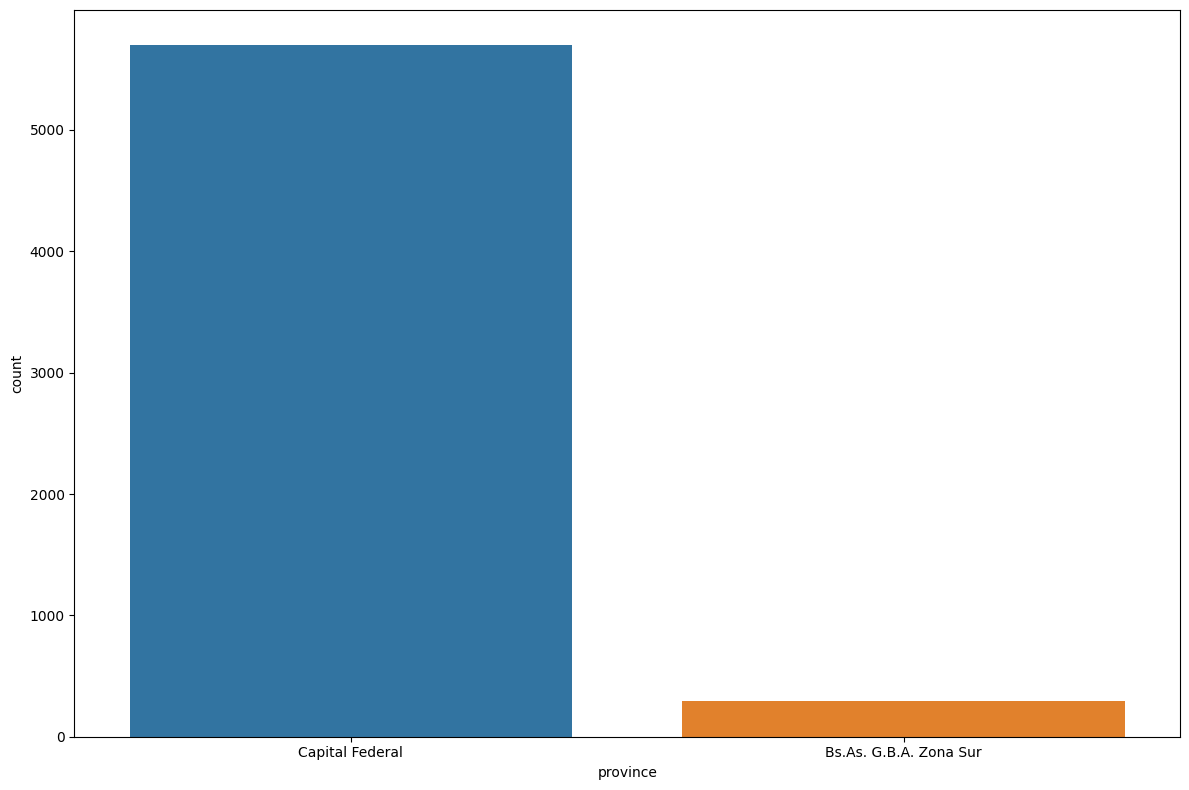

In [184]:
sns.countplot(x = "province", data = df_train[df_train["country"].isin(["Argentina"])])
plt.tight_layout()
plt.show(block=False)

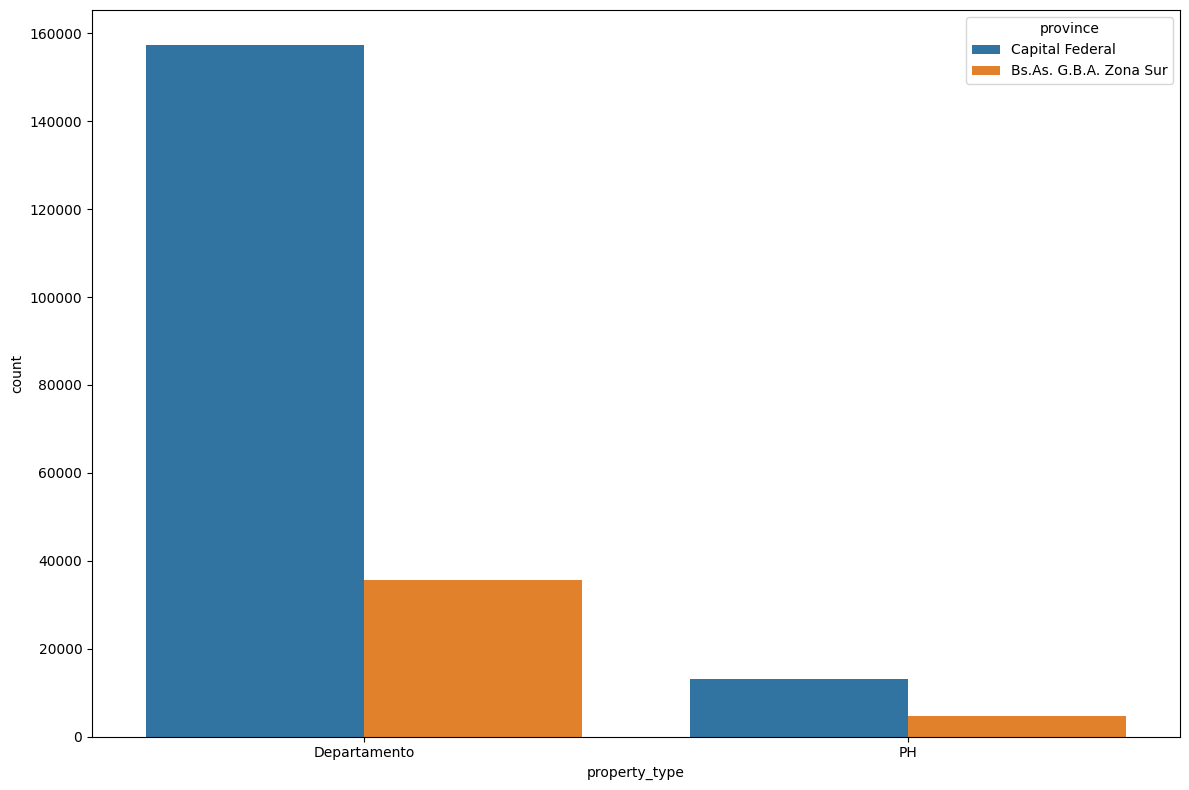

In [318]:
sns.countplot(x = "property_type", data = df_train, hue="province")
plt.tight_layout()
plt.show(block=False)

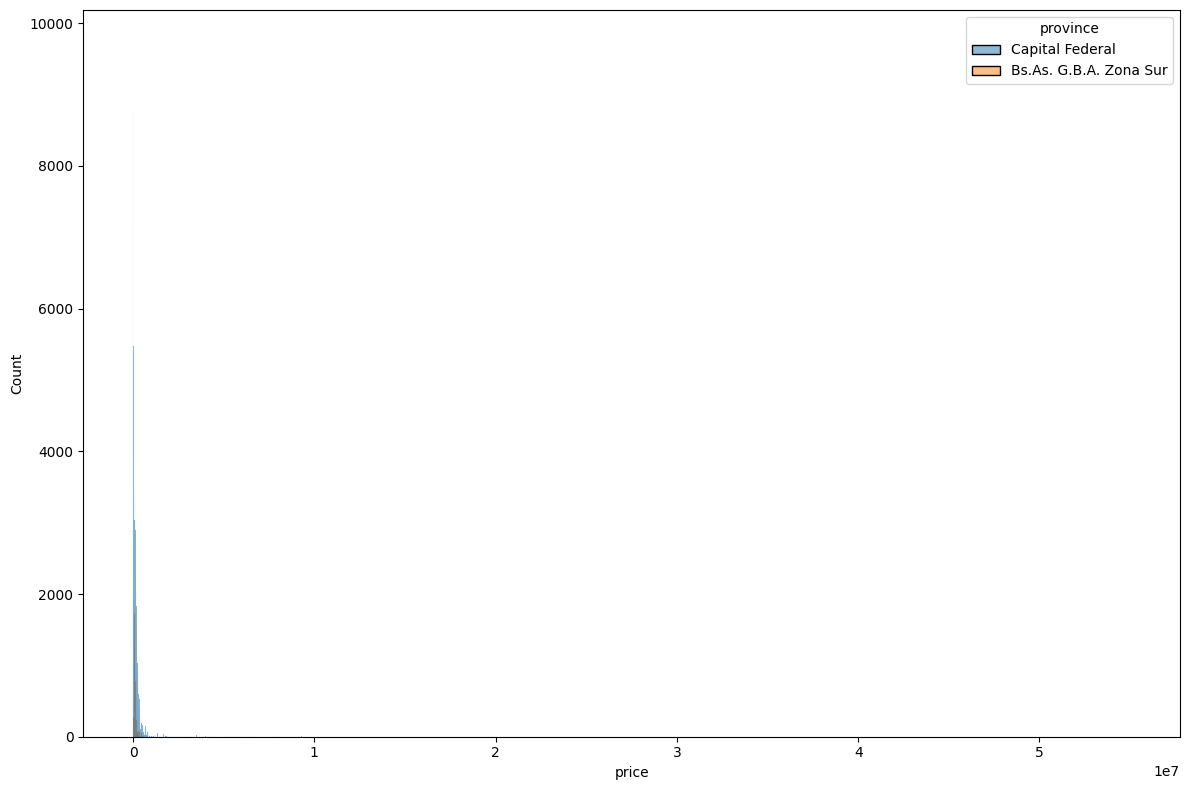

In [319]:
sns.histplot(x = "price", data = df_train, hue="province")
plt.tight_layout()
plt.show(block=False)

In [186]:
df_train = df_train.drop_duplicates(keep="last")

In [187]:
df_train = df_train.reset_index(drop=False)

In [188]:
# to_drop = ['surface_total','surface_covered','rooms','price']
# df_train = df_train.dropna(subset = to_drop, axis = 0)
# df_train.head(2)

In [189]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     5963 non-null   int64         
 1   ad_type                5963 non-null   object        
 2   start_date             5963 non-null   datetime64[ns]
 3   end_date               4783 non-null   datetime64[ns]
 4   created_on             5963 non-null   datetime64[ns]
 5   lat                    5513 non-null   float64       
 6   lon                    5514 non-null   float64       
 7   country                5963 non-null   object        
 8   province               5963 non-null   object        
 9   city                   5752 non-null   object        
 10  neigborhood            456 non-null    object        
 11  published_neigborhood  0 non-null      float64       
 12  rooms                  5963 non-null   float64       
 13  bed

In [190]:
df_train.isnull().sum().rename_axis("Feature", axis=0).sort_values(ascending=False).to_frame("Missing Values") / len(df_train)

,Missing Values
Feature,
price,1.000000
published_neigborhood,1.000000
neigborhood,0.923528
price_period,0.680530
surface_total,0.204427
end_date,0.197887
surface_covered,0.187322
bedrooms,0.177595
lat,0.075465


In [191]:
wrong_surface_rows = df_train[df_train['surface_total'] < df_train['surface_covered']]
len(wrong_surface_rows)

39

In [192]:
df_train.loc[wrong_surface_rows.index, 'surface_total']

190     39.0
249     36.0
266     37.0
694     36.0
701     53.0
913     58.0
916     11.0
1062    46.0
1214    51.0
1358    74.0
1497    34.0
1499    82.0
1512    51.0
1594    57.0
1710    10.0
1769    75.0
1789    76.0
2173    32.0
2211    42.0
2297    30.0
2556    53.0
2720    49.0
2822    54.0
3084    38.0
3465    49.0
3613    63.0
3614    50.0
3663    25.0
3754    63.0
3878    42.0
3891    29.0
3898    29.0
4018    46.0
4116    63.0
4324    39.0
5360    51.0
5692    28.0
5917    20.0
5942    33.0
Name: surface_total, dtype: float64

In [193]:
df_train.loc[pd.Series(wrong_surface_rows.index), 'surface_total'] = wrong_surface_rows.surface_covered
df_train.loc[pd.Series(wrong_surface_rows.index), 'surface_covered'] = wrong_surface_rows.surface_total

In [194]:
conteo_puntos = df_train.groupby(['lat', 'lon']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

lat         lon       
-58.455819  -34.579326    28
-58.445498  -34.597256    21
-58.420122  -34.588007    16
-58.451789  -34.604387    15
-58.421008  -34.608248    14
-58.402925  -34.604328    13
-58.420728  -34.589767    12
-58.420994  -34.611445    12
-58.417970  -34.603810    12
-58.432771  -34.603219    11
dtype: int64

In [195]:
df_train[["lat", "lon"]] = df_train[["lon","lat"]]

In [196]:
conteo_puntos = df_train.groupby(['lat', 'lon']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

lat         lon       
-34.579326  -58.455819    28
-34.597256  -58.445498    21
-34.588007  -58.420122    16
-34.604387  -58.451789    15
-34.608248  -58.421008    14
-34.604328  -58.402925    13
-34.589767  -58.420728    12
-34.603810  -58.417970    12
-34.611445  -58.420994    12
-34.593371  -58.442232    11
dtype: int64

In [197]:
conteo_puntos.name = 'conteo'
df_train = df_train.join(conteo_puntos, on=['lat', 'lon'])
df_train = df_train[df_train.conteo <= 5]

In [198]:
geolocator = Nominatim(user_agent="Bing")
location = geolocator.reverse(Latitude+","+Longitude)
location.raw["address"]["suburb"]

'Chacarita'

In [199]:
df_train.drop('conteo', inplace=True, axis=1)

In [202]:
total_propiedades = df_train.groupby('neigborhood')['property_type'].count().values

In [203]:
porcentaje_casas_ph = df_train[df_train.property_type.isin(['PH', 'Casa'])].groupby('l3').count().property_type/total_propiedades
porcentaje_edificios = df_train[df_train.property_type == 'Departamento'].groupby('l3').count().property_type

KeyError: 'l3'

# Limpieza y transformación de datos (magia parte 2 -- MD)

In [ ]:
# Selección de datos. Solo a fines demostrativos. Cambiar!
df_train = df_train.loc[(df_train.l2 == "Córdoba") & (df_train.operation_type == 'Venta') & (df_train.property_type == 'Casa')]
df_train.shape

(11100, 24)

In [ ]:
## esto tiene que hacerse antes y mejor
df_train.fillna(0, inplace=True, downcast= "infer")
df_test.fillna(0, inplace=True, downcast= "infer") 

In [ ]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos

    return (X_train, y_train, X_test)

# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [ ]:
# Datos para probar
df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [ ]:
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en test
    score_train = sk.metrics.mean_squared_error(y_train, y_pred)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=} {score_test=}")
    

print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

fold=0, score_train=656619551068.9652 score_test=723458864862.029
fold=1, score_train=705282813566.9788 score_test=407119553109.7009
fold=2, score_train=643023999928.6862 score_test=994184852024.9316
fold=3, score_train=665345121159.0591 score_test=1046921316854.067
fold=4, score_train=676453853218.504 score_test=1078025506441.9459
fold=5, score_train=711032810564.2731 score_test=369502566520.8514
fold=6, score_train=691216432021.5255 score_test=459109057184.1242
fold=7, score_train=692006631232.408 score_test=611882224415.666
fold=8, score_train=625610260389.6654 score_test=1308765643364.4905
fold=9, score_train=633034962823.5765 score_test=1188451212540.4434
Train scores mean=669962643597.3641, std=30129180014.069405
Test scores mean=818742079731.825, std=346303785730.9732


# Predicción para kaggle


In [ ]:
## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
df_test['price'].to_csv('solucion.csv', index=True)

In [ ]:
pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False)

,column,feature_importance
1,lon,0.284658
0,lat,0.212267
4,rooms,0.141806
8,surface_covered,0.125101
5,bedrooms,0.095744
7,surface_total,0.073814
6,bathrooms,0.066611
2,l5,0.000000
3,l6,0.000000
